<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/06_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [46]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [47]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a

        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) - log_det_j).mean()
        return loss

In [48]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

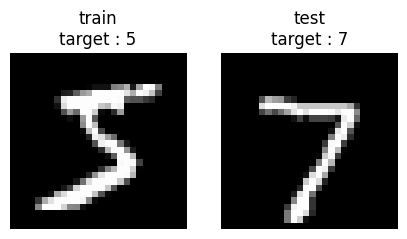

In [49]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [50]:
data_dim = 28*28

prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=15)

train_loader = DataLoader(train_data, batch_size=30000, shuffle=True)


In [51]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1126.8200073242188
Epoch :  2   -----------> Loss :  1110.1734619140625
Epoch :  3   -----------> Loss :  1101.3703002929688
Epoch :  4   -----------> Loss :  1093.331298828125
Epoch :  5   -----------> Loss :  1085.3616943359375
Epoch :  6   -----------> Loss :  1077.453369140625
Epoch :  7   -----------> Loss :  1069.5526733398438
Epoch :  8   -----------> Loss :  1061.62841796875
Epoch :  9   -----------> Loss :  1053.6825561523438
Epoch :  10   -----------> Loss :  1045.7620849609375
Epoch :  11   -----------> Loss :  1037.7437133789062
Epoch :  12   -----------> Loss :  1029.7688598632812
Epoch :  13   -----------> Loss :  1021.7808227539062
Epoch :  14   -----------> Loss :  1013.894775390625
Epoch :  15   -----------> Loss :  1006.0228881835938
Epoch :  16   -----------> Loss :  998.1124267578125
Epoch :  17   -----------> Loss :  990.3771057128906
Epoch :  18   -----------> Loss :  982.5010375976562
Epoch :  19   -----------> Loss :  974.648986

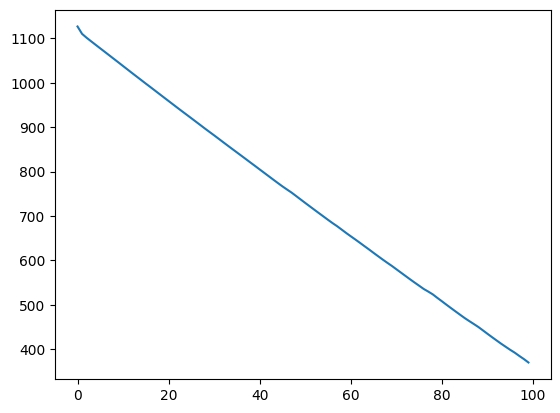

In [52]:
plt.plot(COST)

In [53]:
test = prior.sample((50,))
test

tensor([[-1.4829e+00,  7.3849e-01, -8.0807e-01,  ..., -5.5039e-01,
         -9.1284e-01, -5.5689e-01],
        [ 1.9653e+00,  2.1350e-04,  1.5480e+00,  ...,  7.5422e-02,
         -5.4528e-01,  1.2323e+00],
        [ 1.0710e+00, -1.6998e+00,  1.7404e-01,  ...,  1.7142e-01,
         -1.4225e+00, -8.0488e-01],
        ...,
        [ 7.6778e-01, -4.6505e-01, -1.3283e+00,  ..., -1.0183e+00,
          1.5909e+00,  3.0656e-01],
        [-9.1278e-01, -4.8383e-01, -1.1598e+00,  ..., -1.2181e+00,
         -1.1245e+00, -1.0422e+00],
        [ 8.7988e-03, -3.9001e-01, -5.4993e-01,  ...,  1.2768e+00,
          2.1661e+00, -6.5909e-01]])

In [54]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 0.7717,  0.2870, -0.6704,  ..., -0.7624,  0.3522,  1.0889],
        [-0.0999, -0.0292, -0.1545,  ...,  1.8074,  0.2333,  0.6039],
        [ 0.0386,  1.1342, -0.2494,  ...,  1.1123,  0.3391,  0.3705],
        ...,
        [ 1.3127, -1.7055,  0.6296,  ...,  0.4975,  0.3928, -0.4040],
        [ 0.3929, -0.3884, -0.3739,  ...,  2.2825,  0.5534, -0.0792],
        [ 1.0522,  0.4354,  0.3468,  ...,  1.4253, -0.5321, -0.9101]],
       grad_fn=<MulBackward0>)

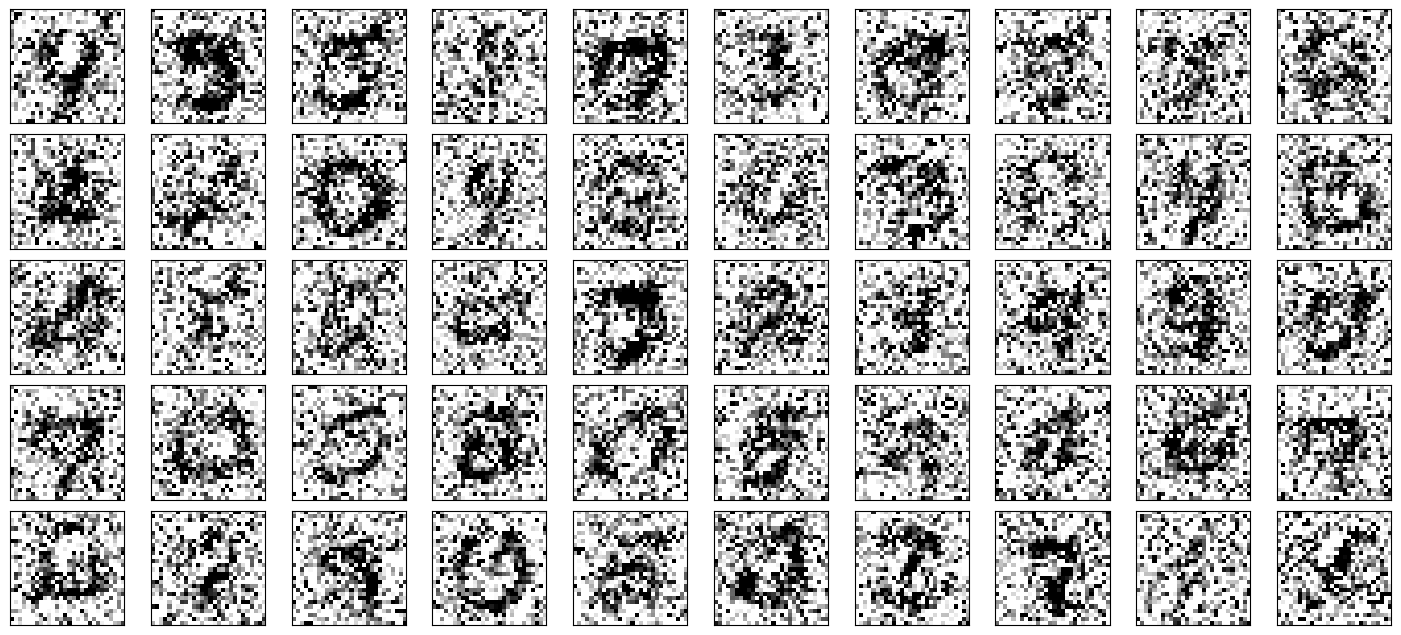

In [59]:
test = prior.sample((50,))
sonuc = torch.nn.ReLU()(model.f_inv(test))

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 1))

fig.show()